In [41]:
import pandas as pd

dataset = pd.read_csv("lung_cancer_dataset.csv")

# Convert text to categorical data
dataset['gender'] = dataset['gender'].astype('category')
dataset['radon_exposure'] = dataset['radon_exposure'].astype('category')
dataset['alcohol_consumption'] = dataset['alcohol_consumption'].fillna('None').astype('category')

dataset['asbestos_exposure'] = dataset['asbestos_exposure'].map({'Yes': True, 'No': False})
dataset['secondhand_smoke_exposure'] = dataset['secondhand_smoke_exposure'].map({'Yes': True, 'No': False})
dataset['copd_diagnosis'] = dataset['copd_diagnosis'].map({'Yes': True, 'No': False})
dataset['family_history'] = dataset['family_history'].map({'Yes': True, 'No': False})
dataset['lung_cancer'] = dataset['lung_cancer'].map({'Yes': True, 'No': False})

# no duplicate rows
dataset.duplicated().sum()

# show data
dataset.head()

,patient_id,age,gender,pack_years,radon_exposure,asbestos_exposure,secondhand_smoke_exposure,copd_diagnosis,alcohol_consumption,family_history,lung_cancer
0,100000,69,Male,66.025244,High,False,False,True,Moderate,False,False
1,100001,32,Female,12.780800,High,False,True,True,Moderate,True,True
2,100002,89,Female,0.408278,Medium,True,True,True,None,False,True
3,100003,78,Female,44.065232,Low,False,True,False,Moderate,False,True
4,100004,38,Female,44.432440,Medium,True,False,True,None,True,True


In [42]:
from sklearn.model_selection import train_test_split

# Aufteilen in Trainings- und Testdaten
data = dataset.loc[:, 'age':'family_history']
target = dataset['lung_cancer']
train_data, test_data, train_label, test_label = train_test_split(data, target, test_size=0.2, random_state=42)

In [43]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, RobustScaler

# Spaltennamen nach Typ trennen
categorical_cols = data.select_dtypes(include=['category']).columns.tolist()
numeric_cols = data.select_dtypes(include=['number', 'bool']).columns.tolist()

# Preprocessing-Transformer (numerisch: RobustScaler, kategorisch: OneHotEncoder)
preprocessor = ColumnTransformer([
    ("numeric", RobustScaler(), numeric_cols), # RobustScaler() hat keine/kaum Auswirkung
    ("categorical", OneHotEncoder(drop='first'), categorical_cols)
])

In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

# Neue Pipeline mit Klassifikator
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(solver='liblinear')) # Hier kommt der Klassifikator
])

# Pipeline trainieren
logistic_pipeline.fit(train_data, train_label)

# Vorhersagen treffen
y_pred = logistic_pipeline.predict(test_data)

# Genauigkeit bewerten
accuracy = accuracy_score(test_label, y_pred)
print(f"Genauigkeit: {accuracy:.2f}")

Genauigkeit: 0.72


In [45]:
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(test_label, y_pred))
print("\nKlassifikationsbericht:")
print(classification_report(test_label, y_pred))

Confusion Matrix:
[[1049 2069]
 [ 731 6151]]

Klassifikationsbericht:
              precision    recall  f1-score   support

       False       0.59      0.34      0.43      3118
        True       0.75      0.89      0.81      6882

    accuracy                           0.72     10000
   macro avg       0.67      0.62      0.62     10000
weighted avg       0.70      0.72      0.69     10000



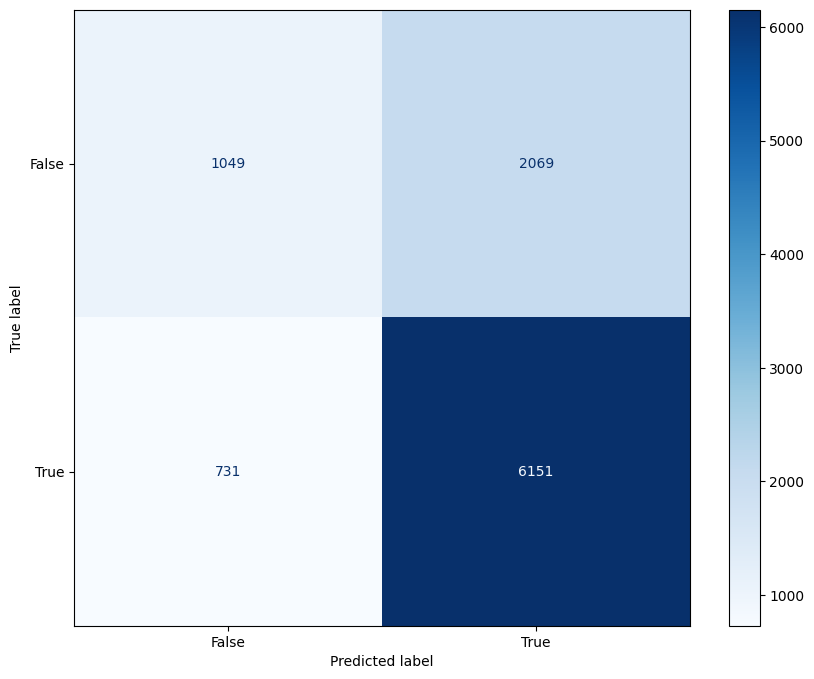

In [46]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, figsize=(10, 8))
_ = ConfusionMatrixDisplay.from_estimator(
    logistic_pipeline, 
    test_data, 
    test_label, 
    display_labels=dataset['lung_cancer'].unique(),
    cmap=plt.cm.Blues,
    ax=ax
)

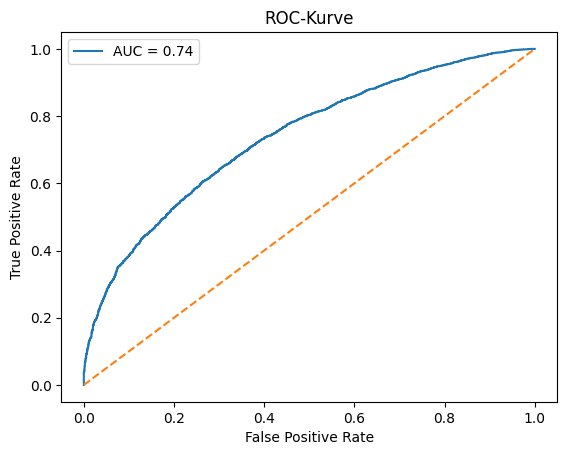

In [47]:
# Berechnung ROC-Kurve und AUC-Score
from sklearn.metrics import roc_curve, roc_auc_score

y_pred_proba = logistic_pipeline.predict_proba(test_data)[:, 1]
fpr, tpr, _ = roc_curve(test_label, y_pred_proba)
auc = roc_auc_score(test_label, y_pred_proba)

plt.plot(fpr, tpr, label=f"AUC = {auc:.2f}")
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-Kurve')
plt.legend()
plt.show()

In [48]:
# Kreuzvalidierung
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(logistic_pipeline, data, target, cv=5, scoring='accuracy')
print(f"Mittlere Kreuzvalidierungsgenauigkeit: {cv_scores.mean():.2f}")

Mittlere Kreuzvalidierungsgenauigkeit: 0.72


In [49]:
# Koeffizienten interpretieren
model = logistic_pipeline.named_steps['classifier']

encoded_feature_names = logistic_pipeline.named_steps['preprocessor'].get_feature_names_out()
coefficients = model.coef_[0]

coef_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Koeffizient': coefficients
}).sort_values(by='Koeffizient', ascending=False)

print(coef_df)

                                      Feature  Koeffizient
1                         numeric__pack_years     0.925132
2                  numeric__asbestos_exposure     0.799817
4                     numeric__copd_diagnosis     0.769866
5                     numeric__family_history     0.557759
0                                numeric__age     0.531796
3          numeric__secondhand_smoke_exposure     0.475534
6                    categorical__gender_Male     0.009425
9   categorical__alcohol_consumption_Moderate    -0.184558
10      categorical__alcohol_consumption_None    -0.197812
7             categorical__radon_exposure_Low    -0.743158
8          categorical__radon_exposure_Medium    -0.762366


Koeffezienten von logistischer Regression in Odds Ratios umrechnen (besseres Verständnis)
- Odds Ratio > 1 -> erhöht das Lungenkrebsrisiko
- Odds Ratio < 1 -> senkt das Lungenkrebsrisiko
- Odds Ratio = 1 -> kein Einfluss auf Lungenkrebsrisiko

In [50]:
import numpy as np

odds_ratios = np.exp(coefficients)
odds_df = pd.DataFrame({
    'Feature': encoded_feature_names,
    'Koeffizient': coefficients,
    'Odds Ratio': odds_ratios
}).sort_values(by='Odds Ratio', ascending=False)

print(odds_df)

                                      Feature  Koeffizient  Odds Ratio
1                         numeric__pack_years     0.925132    2.522202
2                  numeric__asbestos_exposure     0.799817    2.225133
4                     numeric__copd_diagnosis     0.769866    2.159477
5                     numeric__family_history     0.557759    1.746753
0                                numeric__age     0.531796    1.701986
3          numeric__secondhand_smoke_exposure     0.475534    1.608873
6                    categorical__gender_Male     0.009425    1.009470
9   categorical__alcohol_consumption_Moderate    -0.184558    0.831472
10      categorical__alcohol_consumption_None    -0.197812    0.820524
7             categorical__radon_exposure_Low    -0.743158    0.475610
8          categorical__radon_exposure_Medium    -0.762366    0.466561


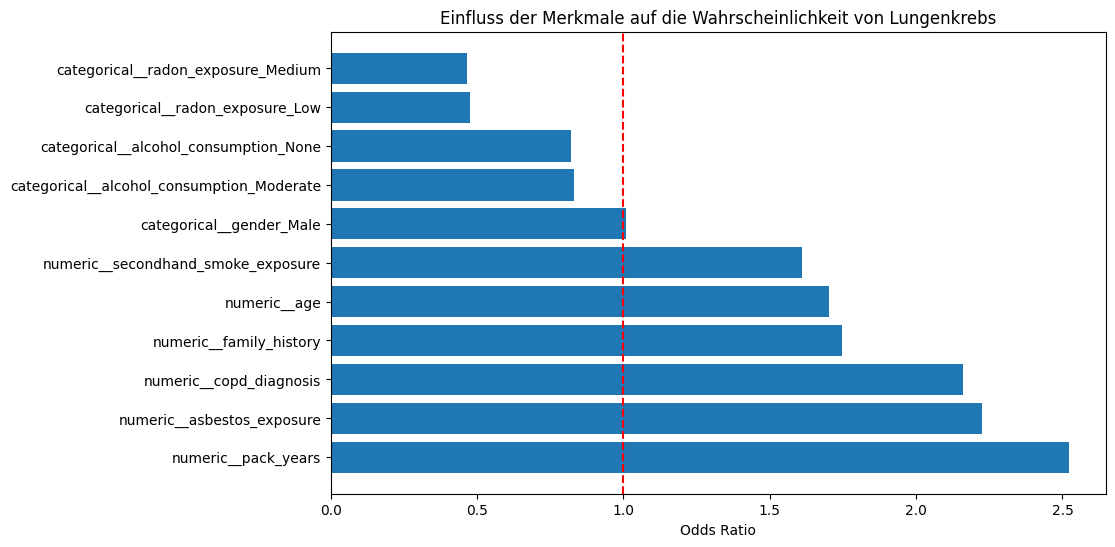

In [51]:
# Visualisierung der Odds Ratios
plt.figure(figsize=(10, 6))
plt.barh(odds_df['Feature'], odds_df['Odds Ratio'])
plt.xlabel('Odds Ratio')
plt.title('Einfluss der Merkmale auf die Wahrscheinlichkeit von Lungenkrebs')
plt.axvline(x=1, color='red', linestyle='--')
plt.show()

Signifikanz der Regressionskoeffizienten mit statsmodels (funktioniert gleich wie sklearn.linear_model.LogisticRegression). <br> 
Gibt Übersicht über
- Koeffizienten
- Standardfehler
- z-Werte
- p-Werte
- Konfidenzintervalle

In [52]:
import statsmodels.api as sm

# One-Hot-Encoding manuell für statsmodels
X_prep = pd.get_dummies(data, drop_first=True)
X_prep = X_prep.astype(float)
X_prep = sm.add_constant(X_prep)

model_sm = sm.Logit(target, X_prep)
result = model_sm.fit()

print(result.summary())

Optimization terminated successfully.
         Current function value: 0.541439
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:            lung_cancer   No. Observations:                50000
Model:                          Logit   Df Residuals:                    49988
Method:                           MLE   Df Model:                           11
Date:                Mon, 13 Oct 2025   Pseudo R-squ.:                  0.1285
Time:                        11:16:17   Log-Likelihood:                -27072.
converged:                       True   LL-Null:                       -31063.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                   coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------------
const                           -1.4020      0.046    -30.159      0.000

Zusammenfassung der Ergebnisse

In [53]:
print("\n--- Zusammenfassung ---")
print(f"Testgenauigkeit: {accuracy:.2f}")
print(f"AUC-Score: {auc:.2f}")
print("Top 5 einflussreichste Variablen:")
print(odds_df.head(5))


--- Zusammenfassung ---
Testgenauigkeit: 0.72
AUC-Score: 0.74
Top 5 einflussreichste Variablen:
                      Feature  Koeffizient  Odds Ratio
1         numeric__pack_years     0.925132    2.522202
2  numeric__asbestos_exposure     0.799817    2.225133
4     numeric__copd_diagnosis     0.769866    2.159477
5     numeric__family_history     0.557759    1.746753
0                numeric__age     0.531796    1.701986
